# Combustion Chemistry in Isobaric Reactor: Analyzing the Principal Components of the $R_{H}$ Data Matrix

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')


### Importing External Libraries

import numpy                             as np
import pandas                            as pd
pd.options.mode.chained_assignment = None  # default='warn'


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


from scipy.integrate import solve_ivp
import pyDOE    
from PCAfold         import PCA          as PCAA

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

3.9.12 (main, Mar 26 2022, 15:51:13) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
DataDir            = os.path.join(WORKSPACE_PATH, 'ROMNet/Data/0DReact_Isobaric_500Cases_H2/')
FigDir             = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_/')

tStratch           = 1.
SOLVER             = 'BDF'

valid_perc         = 20.

FixedMinVal        = 1.e-32

PCA_NAME           = 'HNO'
VarName            = 'HNO'
#PCA_NAME           = 'All'

if (PCA_NAME == 'All'):
    n_modesFinal   = 64
    PCAType        = 'All'
else:
    n_modesFinal   = 64
    PCAType        = 'OneByOne'
    
    
ColorVec           = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

try:
    os.makedirs(DataDir)
except OSError as e:
    pass
try:
    os.makedirs(DataDir+'/Orig/'+str(PCAType))
except:
    pass

In [3]:
FileName   = DataDir + '/Orig//train/ext/CleanVars.csv'
Vars       = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()[0,:]
NVars      = len(Vars)

iVar       = list(Vars).index(PCA_NAME)

In [4]:
FileName     = DataDir + '/Orig/train/ext/ICs.csv'
Data         = pd.read_csv(FileName)
ICVecs       = Data.to_numpy()
n_ics         = len(ICVecs)

In [5]:
if (PCA_NAME == 'All'):
    
    Cols   = []
    NewFlg = True
    for iC in range(100):


        FileName             = DataDir+'/Orig/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[[Vars[iVar] for iVar in range(NVars)]]
        DataTemp             = np.maximum(DataTemp, FixedMinVal)


        Flg = True
        for iVar in range(NVarsRed):
            if (np.abs( (DataTemp[Vars[iVar]][0] - DataTemp[Vars[iVar]][len(Data)-1])/DataTemp[Vars[iVar]][0] ) < 1.e-4): 
                Flg = False
                break
        
        if Flg:
            DataICTemp  = Data[[Vars[iVar] for iVar in range(NVars)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols += [str(iC+1)+'_'+str(iVar+1) for iVar in range(NVars)]
            
        else:
            print('iC ', iC)

    tVec              = Data['t']
    DataInput.columns = Cols
    
    yMat              = DataInput.to_numpy()
    
else:
    
    Cols   = []
    NewFlg = True
    for iC in range(n_ics):



        FileName             = DataDir+'/Orig/train/ext/y.csv.'+str(iC+1)
        Data                 = pd.read_csv(FileName, header=0)
        DataTemp             = Data[Vars[iVar]]
        DataTemp             = np.maximum(DataTemp, FixedMinVal)

        if (np.abs( (DataTemp[0] - DataTemp[len(Data)-1])/DataTemp[0] ) > 1.e-4):
            DataICTemp  = Data[[Vars[iVar] for iVar in range(NVars)]].iloc[0]
            
            if (NewFlg):
                DataInput        = DataTemp
                DataIC           = DataICTemp
                NewFlg           = False
            else:
                DataInput        = pd.concat([DataInput, DataTemp], axis=1)
                DataIC           = pd.concat([DataIC, DataICTemp], axis=1)
            Cols.append(str(iC+1))

    tVec              = Data['t']
    DataInput.columns = Cols

    yMat              = DataInput.to_numpy()
    
DataIC            = DataIC.T.reset_index(drop=True, inplace=False)

In [6]:
ICs = DataIC.to_numpy()

In [7]:
DataInput

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,...,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32,1.000000e-32
1,1.113237e-27,1.263624e-26,3.934653e-25,2.826919e-19,7.024460e-22,3.654037e-30,3.590589e-27,1.266412e-28,1.371003e-21,1.000000e-32,...,8.620149e-23,1.179891e-26,2.467653e-32,2.264068e-19,3.734836e-32,1.504060e-31,3.342389e-19,1.000000e-32,1.696160e-26,7.535583e-20
2,1.301352e-27,1.478670e-26,4.594802e-25,3.259666e-19,8.177572e-22,4.243873e-30,4.202878e-27,1.478624e-28,1.591632e-21,1.000000e-32,...,1.002226e-22,1.379141e-26,2.809566e-32,2.614434e-19,4.245769e-32,1.710711e-31,3.866382e-19,1.000000e-32,1.980177e-26,8.749620e-20
3,1.520968e-27,1.729177e-26,5.364762e-25,3.757459e-19,9.518808e-22,4.926435e-30,4.915160e-27,1.723520e-28,1.847350e-21,1.000000e-32,...,1.164995e-22,1.611637e-26,3.194226e-32,3.018127e-19,4.819071e-32,1.944513e-31,4.471383e-19,1.000000e-32,2.312677e-26,1.015819e-19
4,1.778409e-27,2.021419e-26,6.262837e-25,4.329844e-19,1.107853e-21,5.714757e-30,5.748336e-27,2.021194e-28,2.143653e-21,1.000000e-32,...,1.353899e-22,1.882463e-26,3.625998e-32,3.483086e-19,5.461102e-32,2.208752e-31,5.169698e-19,1.000000e-32,2.700329e-26,1.179217e-19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,3.506159e-08,2.463819e-07,1.615028e-07,1.908542e-07,1.114378e-06,9.167146e-09,6.007746e-07,6.848420e-07,2.276646e-07,3.232065e-07,...,9.764904e-08,2.719850e-07,3.616376e-07,3.032383e-07,5.347742e-07,3.823884e-07,7.790268e-07,2.134984e-09,5.063994e-08,1.131303e-06
496,3.506159e-08,2.463819e-07,1.615028e-07,1.908542e-07,1.114378e-06,9.167146e-09,6.007746e-07,6.848420e-07,2.276646e-07,3.232065e-07,...,9.764904e-08,2.719850e-07,3.616376e-07,3.032383e-07,5.347742e-07,3.823884e-07,7.790268e-07,2.147941e-09,5.063994e-08,1.131303e-06
497,3.506159e-08,2.463819e-07,1.615028e-07,1.908542e-07,1.114378e-06,9.167146e-09,6.007746e-07,6.848420e-07,2.276646e-07,3.232065e-07,...,9.764904e-08,2.719850e-07,3.616376e-07,3.032383e-07,5.347742e-07,3.823884e-07,7.790268e-07,2.160045e-09,5.063994e-08,1.131303e-06
498,3.506159e-08,2.463819e-07,1.615028e-07,1.908542e-07,1.114378e-06,9.167146e-09,6.007746e-07,6.848420e-07,2.276646e-07,3.232065e-07,...,9.764904e-08,2.719850e-07,3.616376e-07,3.032383e-07,5.347742e-07,3.823884e-07,7.790268e-07,2.171307e-09,5.063994e-08,1.131303e-06


In [8]:
# n_modes      = 128
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# plt.figure()
# for j, Scaling in enumerate(ScalingVec):

#     pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes))
#     C          = pca.X_center
#     D          = pca.X_scale
#     A          = pca.A[:,0:n_modes].T
#     L          = pca.L
#     AT         = A.T

#     plt.plot(L, label=Scaling)
    
# plt.xlim([0., 250])
# plt.ylim([1.e-14, 1.e0])
# plt.yscale('log')
# plt.xlabel('Component Index')
# plt.ylabel('Eigenvalue')
# plt.legend(title='Scaling')

# if (FigDir):
#     plt.savefig(FigDir+'/0DReactor_Eigenvalues_OneByOne_'+Vars[iVar]+'.eps', format='eps', bbox_inches='tight')

In [9]:
# n_modesVec   = np.arange(1,60,5)
# ScalingVec = ['none', 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
# #'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

# MaxPerc    = np.zeros((len(n_modesVec), len(ScalingVec)))
# MaxSE      = np.zeros((len(n_modesVec), len(ScalingVec)))
# MeanPerc   = np.zeros((len(n_modesVec), len(ScalingVec)))
# MSE        = np.zeros((len(n_modesVec), len(ScalingVec)))
# for i, n_modes in enumerate(n_modesVec):
#     #print('n_modes = ', n_modes)
    
#     for j, Scaling in enumerate(ScalingVec):

#         pca        = PCAA(yMat, scaling=Scaling, n_components=int(n_modes), nocenter=True)
#         C          = pca.X_center
#         D          = pca.X_scale
#         A          = pca.A[:,0:n_modes].T
#         L          = pca.L
#         AT         = A.T

#         yMat_pca   = ((yMat - C)/D).dot(AT)
#         yMat_      = (yMat_pca.dot(A))*D + C
        
#         MaxPerc[i,j]    = np.max(abs((yMat - yMat_)/yMat)*100)
#         MaxSE[i,j]      = np.max((yMat - yMat_)**2)
#         MeanPerc[i,j]   = np.mean(abs((yMat - yMat_)/yMat)*100)
#         MSE[i,j]        = np.mean((yMat - yMat_)**2)

In [10]:
# plt.figure()
# plt.plot(n_modesVec, MaxPerc, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Max % Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# plt.figure()
# plt.plot(n_modesVec, MaxSE, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Max Squared Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# plt.figure()
# plt.plot(n_modesVec, MeanPerc, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Mean % Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# plt.figure()
# plt.plot(n_modesVec, MSE, label=ScalingVec)
# plt.xlabel('No of Preserved Modes')
# plt.ylabel('Mean Squared Error')
# plt.legend(title='Scaling')
# plt.yscale('log')

# if (FigDir):
#     plt.savefig(FigDir+'/0DReact_MSE_'+Vars[iVar]+'.eps', format='eps', bbox_inches='tight')

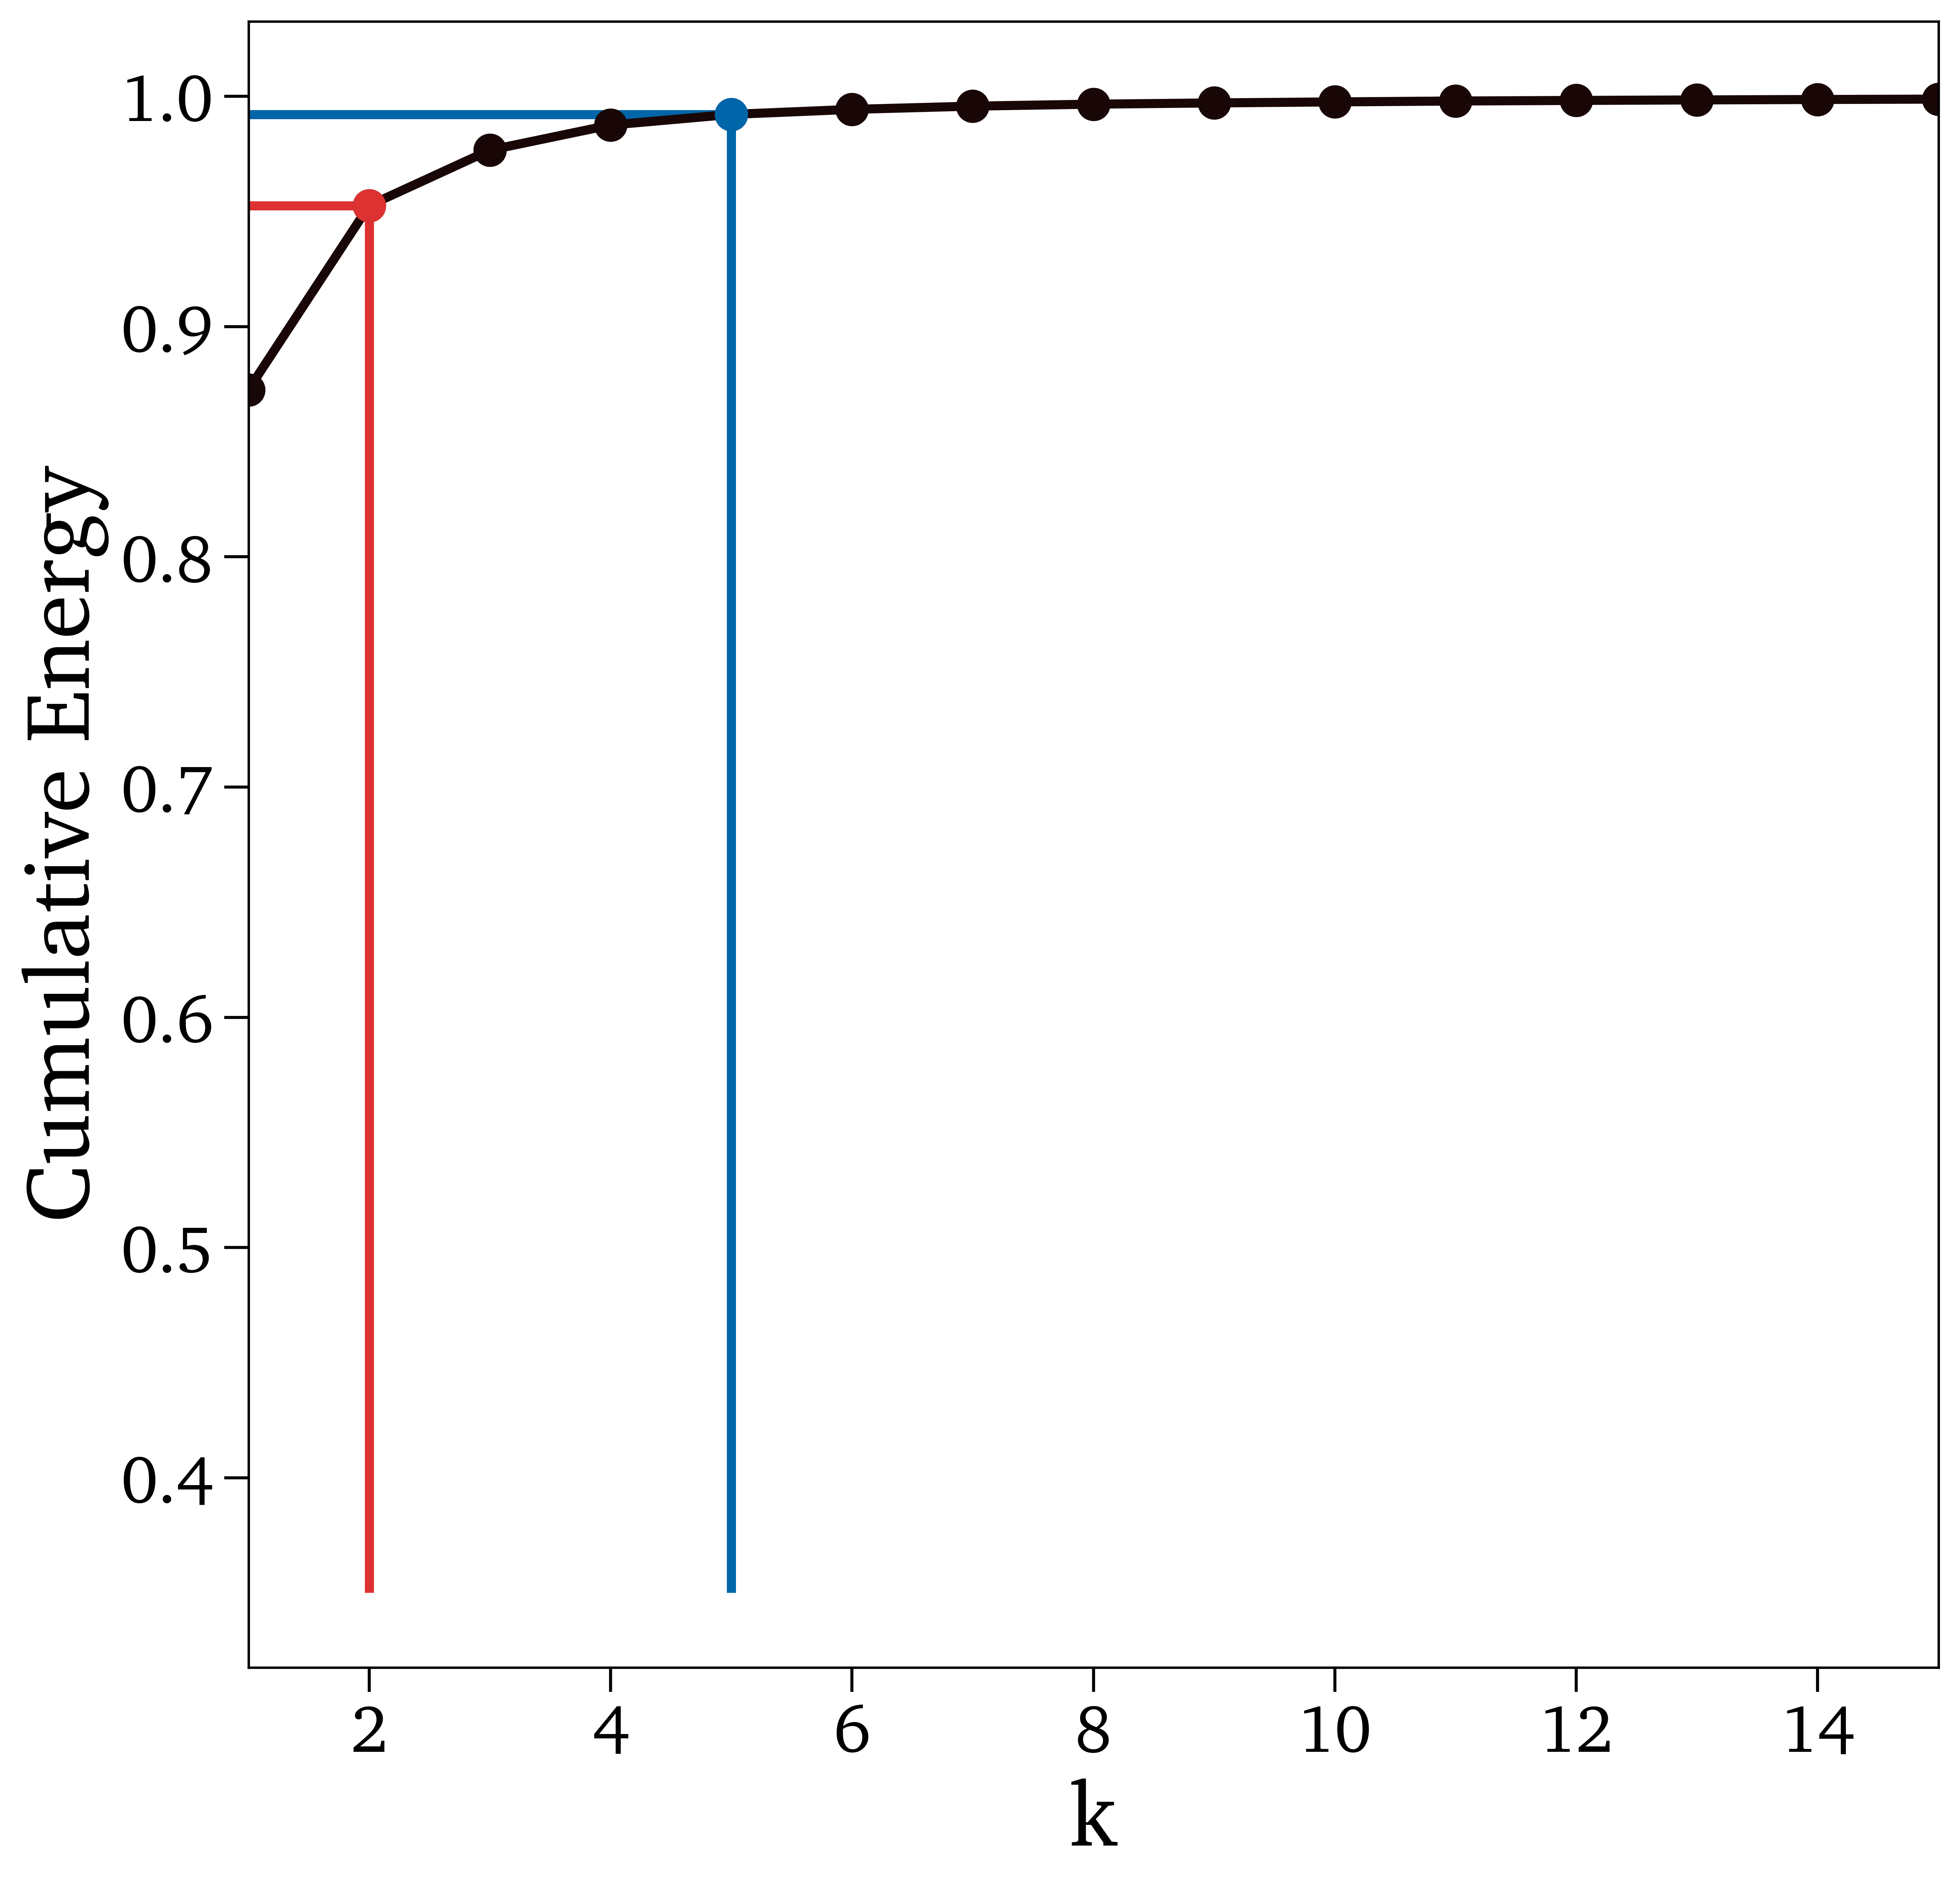

In [11]:
n_modes    = 100
thr1       = 0.95
thr2       = 0.99
thr3       = 0.9999
ScalingVec = ['none']#, 'auto', 'std', 'pareto', 'vast', 'range', '0to1']
             # options: 'none', '', 'auto', 'std', 'pareto', 'vast', 'range', '0to1', '-1to1', 'level', 'max', 'poisson', 'vast_2', 'vast_3', 'vast_4'

fig = plt.figure()
for j, Scaling in enumerate(ScalingVec):

    pca        = PCAA(yMat, scaling='none', n_components=int(n_modes), nocenter=True)
    C          = pca.X_center
    D          = pca.X_scale
    A          = pca.A[:,0:n_modes].T
    L          = pca.L
    LL         = np.maximum(L,0.)
    AT         = A.T
    
    vec        = np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL))
    plt.plot(np.arange(len(vec))+1, vec,'-o')


    kk1        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr1)+1
    plt.plot(kk1, vec[kk1-1], 'o', c=ColorVec[1])
    plt.hlines(vec[kk1-1], xmin=0, xmax=kk1, color=ColorVec[1])
    plt.vlines(kk1, ymin=0.35, ymax=vec[kk1-1], color=ColorVec[1])
    
    kk2        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr2)+1
    plt.plot(kk2, vec[kk2-1], 'o', c=ColorVec[2])
    plt.hlines(vec[kk2-1], xmin=0, xmax=kk2, color=ColorVec[2])
    plt.vlines(kk2, ymin=0.35, ymax=vec[kk2-1], color=ColorVec[2])
    
    kk3        = np.sum(np.cumsum(np.sqrt(LL))/np.sum(np.sqrt(LL)) < thr3)+1

    
plt.xlim([1, kk2+10])
#plt.ylim([0.5, 1.02])
plt.xlabel(r'$k$')
plt.ylabel('Cumulative Energy')
#plt.xticks([1,5,10,15,20])
#plt.yscale('log')

if (FigDir):
    plt.savefig(FigDir+'/0DReact_'+Vars[iVar]+'_CumEnergy.eps', format='eps', bbox_inches='tight')

In [12]:
yMat.shape

(500, 500)

In [13]:
### EXPERIMENTING: ROBUST PCA PREPROCESSING

# from __future__ import division, print_function

# import numpy as np

# try:
#     from pylab import plt
# except ImportError:
#     print('Unable to import pylab. R_pca.plot_fit() will not work.')

# try:
#     # Python 2: 'xrange' is the iterative version
#     range = xrange
# except NameError:
#     # Python 3: 'range' is iterative - no need for 'xrange'
#     pass


# class R_pca:

#     def __init__(self, D, mu=None, lmbda=None):
#         self.D = D
#         self.S = np.zeros(self.D.shape)
#         self.Y = np.zeros(self.D.shape)

#         if mu:
#             self.mu = mu
#         else:
#             self.mu = np.prod(self.D.shape) / (4 * np.linalg.norm(self.D, ord=1))

#         self.mu_inv = 1 / self.mu

#         if lmbda:
#             self.lmbda = lmbda
#         else:
#             self.lmbda = 1 / np.sqrt(np.max(self.D.shape))

#     @staticmethod
#     def frobenius_norm(M):
#         return np.linalg.norm(M, ord='fro')

#     @staticmethod
#     def shrink(M, tau):
#         return np.sign(M) * np.maximum((np.abs(M) - tau), np.zeros(M.shape))

#     def PCA_threshold(self, M, tau):
#         U, S, V = np.linalg.PCA(M, full_matrices=False)
#         return np.dot(U, np.dot(np.diag(self.shrink(S, tau)), V))

#     def fit(self, tol=None, max_iter=1000, iter_print=100):
#         iter = 0
#         err = np.Inf
#         Sk = self.S
#         Yk = self.Y
#         Lk = np.zeros(self.D.shape)

#         if tol:
#             _tol = tol
#         else:
#             _tol = 1E-7 * self.frobenius_norm(self.D)

#         #this loop implements the principal component pursuit (PCP) algorithm
#         #located in the table on page 29 of https://arxiv.org/pdf/0912.3599.pdf
#         while (err > _tol) and iter < max_iter:
#             Lk = self.PCA_threshold(
#                 self.D - Sk + self.mu_inv * Yk, self.mu_inv)                            #this line implements step 3
#             Sk = self.shrink(
#                 self.D - Lk + (self.mu_inv * Yk), self.mu_inv * self.lmbda)             #this line implements step 4
#             Yk = Yk + self.mu * (self.D - Lk - Sk)                                      #this line implements step 5
#             err = self.frobenius_norm(self.D - Lk - Sk)
#             iter += 1
#             if (iter % iter_print) == 0 or iter == 1 or iter > max_iter or err <= _tol:
#                 print('iteration: {0}, error: {1}'.format(iter, err))

#         self.L = Lk
#         self.S = Sk
#         return Lk, Sk

#     def plot_fit(self, size=None, tol=0.1, axis_on=True):

#         n, d = self.D.shape

#         if size:
#             nrows, ncols = size
#         else:
#             sq = np.ceil(np.sqrt(n))
#             nrows = int(sq)
#             ncols = int(sq)

#         ymin = np.nanmin(self.D)
#         ymax = np.nanmax(self.D)
#         print('ymin: {0}, ymax: {1}'.format(ymin, ymax))

#         numplots = np.min([n, nrows * ncols])
#         plt.figure()

#         for n in range(numplots):
#             plt.subplot(nrows, ncols, n + 1)
#             plt.ylim((ymin - tol, ymax + tol))
#             plt.plot(self.L[n, :] + self.S[n, :], 'r')
#             plt.plot(self.L[n, :], 'b')
#             if not axis_on:
#                 plt.axis('off')

In [14]:
# LL, SS = R_pca(yMat).fit(max_iter=1500)#tol=5.e-5)

In [15]:
# iVar = 0

# fig = plt.figure(figsize=(12,8))
# plt.plot(yMat[:,iVar])
# plt.plot(LL[:,iVar])


# fig = plt.figure(figsize=(12,8))
# plt.plot(SS[:,iVar])

In [16]:
n_modesFinal = 20

pca        = PCAA(yMat, scaling='none', n_components=n_modesFinal, nocenter=True)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:n_modesFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (20, 500)
[PCA] 


In [17]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (500, 20)
[PCA]  Max % Error =  6.294296326306207e+17
[PCA]  Max      SE =  3.455450781588032e-18
[PCA] Mean % Error =  290649651704730.4
[PCA]          MSE =  3.439138567722078e-21


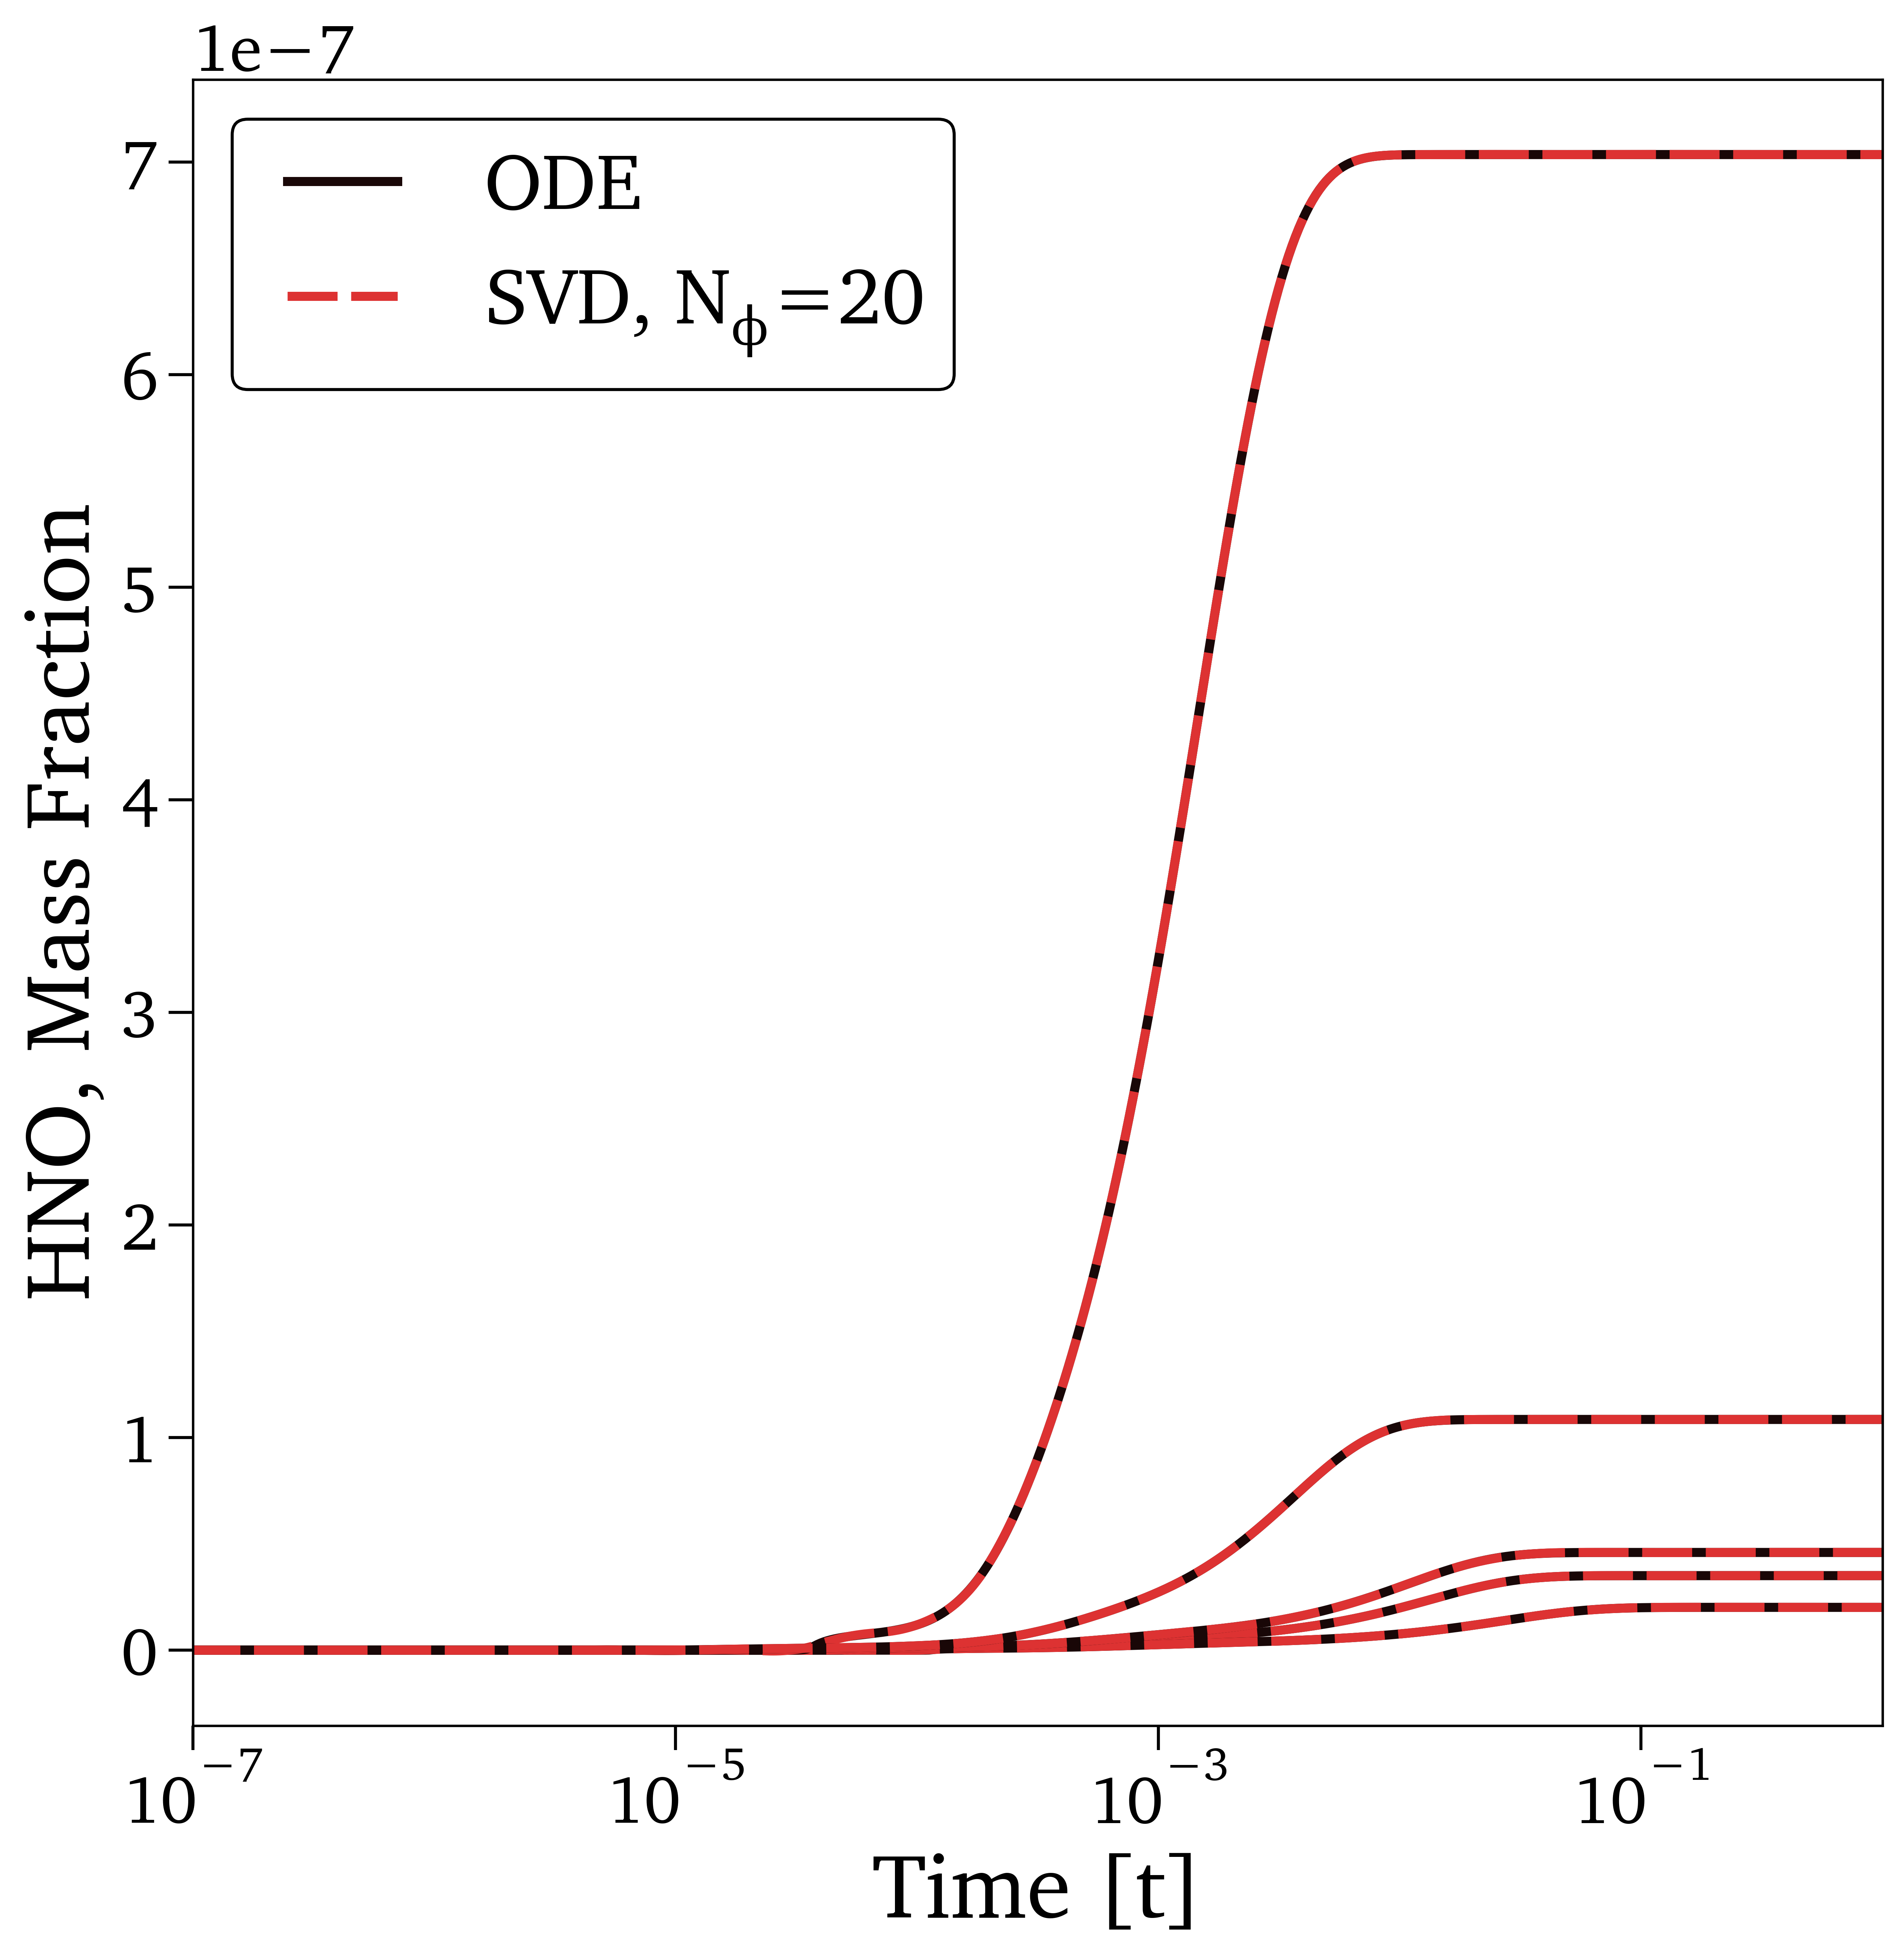

In [18]:
plt.figure()
jCase = 0
for iCase in range(0,500,100):
    if (jCase == 0):
        Label1 = 'ODE'
        Label2 = 'SVD, $N_{\phi}$='+str(n_modesFinal)
    else:
        Label1 = ''
        Label2 = ''

    plt.plot(tVec, yMat[:,iCase],  '-', c=ColorVec[0], label=Label1)
    plt.plot(tVec, yMat_[:,iCase], '--', c=ColorVec[1], label=Label2)
    
    jCase += 1 
    
plt.legend()
plt.xlabel('Time [t]')
if (VarName == 'T'):
    plt.ylabel(r'Temperature [K]')
else:
    plt.ylabel(r'$'+VarName+'$, Mass Fraction')
plt.xscale('log')
plt.xlim([1.e-7,1.0])

if (FigDir):
    plt.savefig(FigDir+'/0DReact_PCA_'+Vars[iVar]+'_Reconstructed_'+str(n_modesFinal)+'.eps', format='eps', bbox_inches='tight')

In [19]:
n_modesFinal = 64

pca        = PCAA(yMat, scaling='std', n_components=n_modesFinal, nocenter=False)
C          = pca.X_center
D          = pca.X_scale
A          = pca.A[:,0:n_modesFinal].T
L          = pca.L
AT         = A.T
print('[PCA] Shape of A        = ', A.shape)
print('[PCA] ')

[PCA] Shape of A        =  (64, 500)
[PCA] 


In [20]:
#yMat_pca    = pca.transform(yMat, nocenter=False)
yMat_pca   = ((yMat - C)/D).dot(AT)

yMat_      = (yMat_pca.dot(A))*D + C
print('[PCA] Shape of yMat_pca = ', yMat_pca.shape)
print('[PCA]  Max % Error = ', np.max(abs((yMat - yMat_)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - yMat_)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - yMat_)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - yMat_)**2))

[PCA] Shape of yMat_pca =  (500, 64)
[PCA]  Max % Error =  1.1925133861652154e+23
[PCA]  Max      SE =  7.723668567224006e-20
[PCA] Mean % Error =  1.2830054282719615e+19
[PCA]          MSE =  6.689992828165451e-23


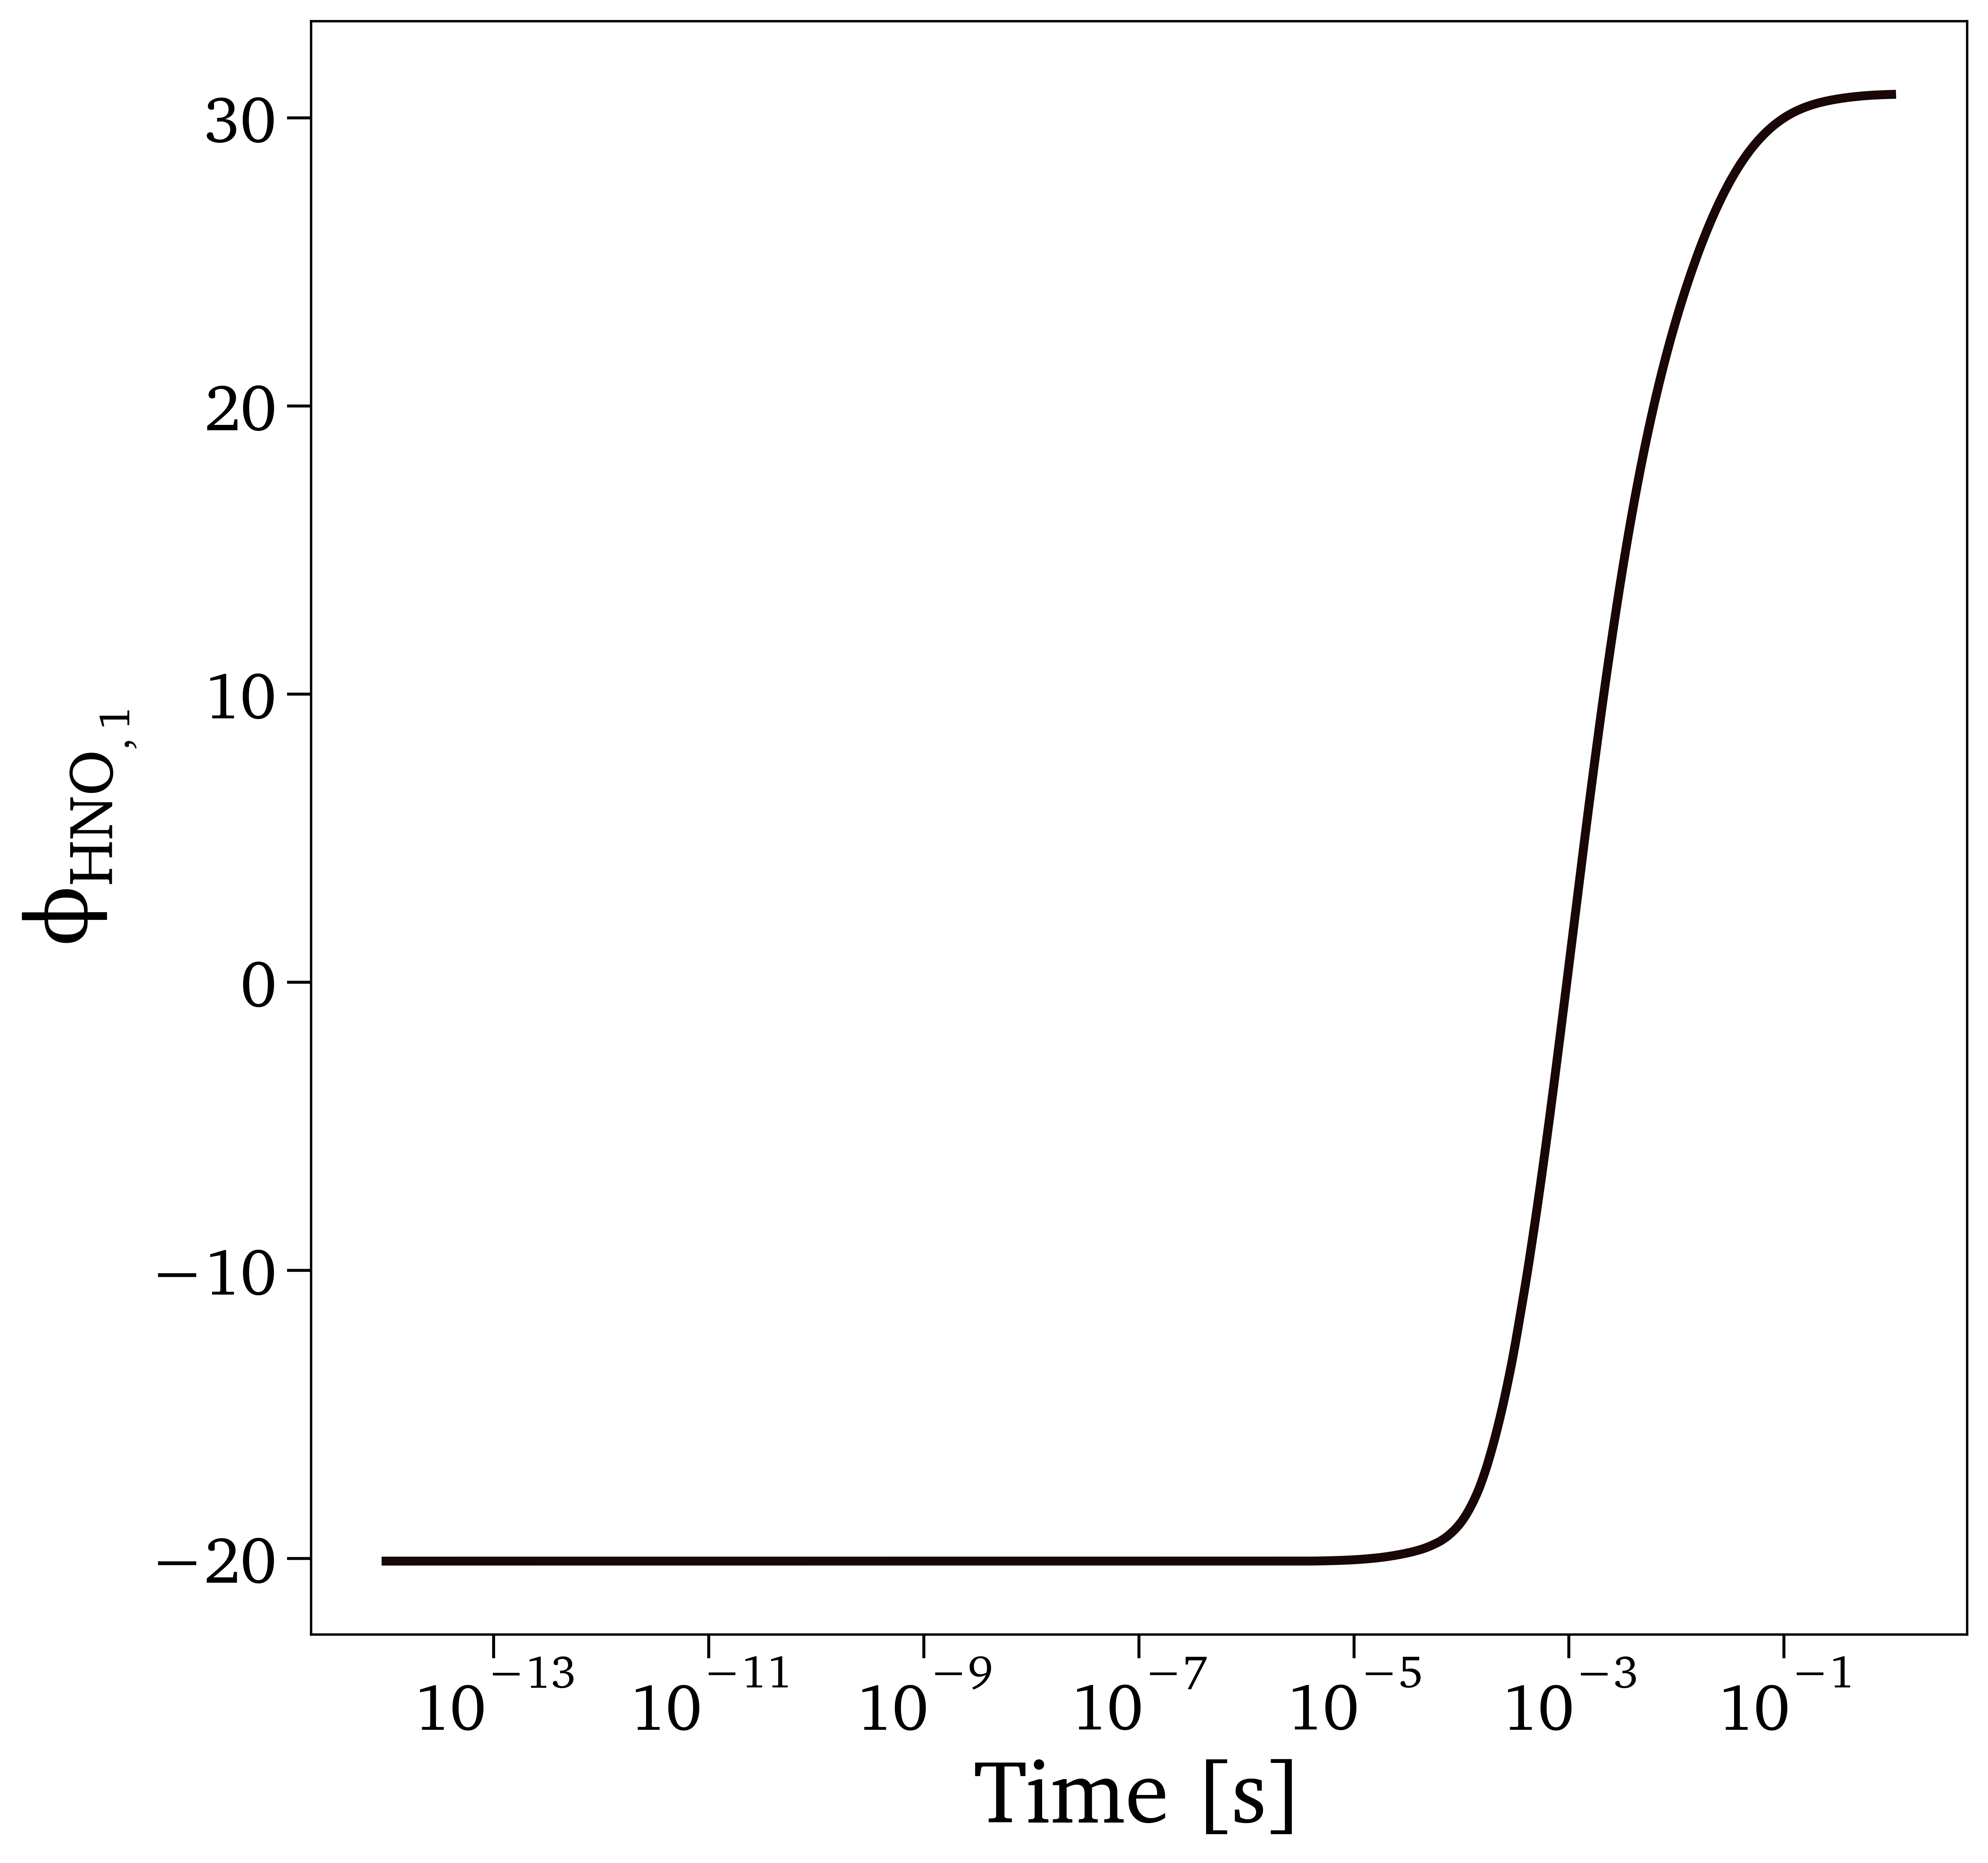

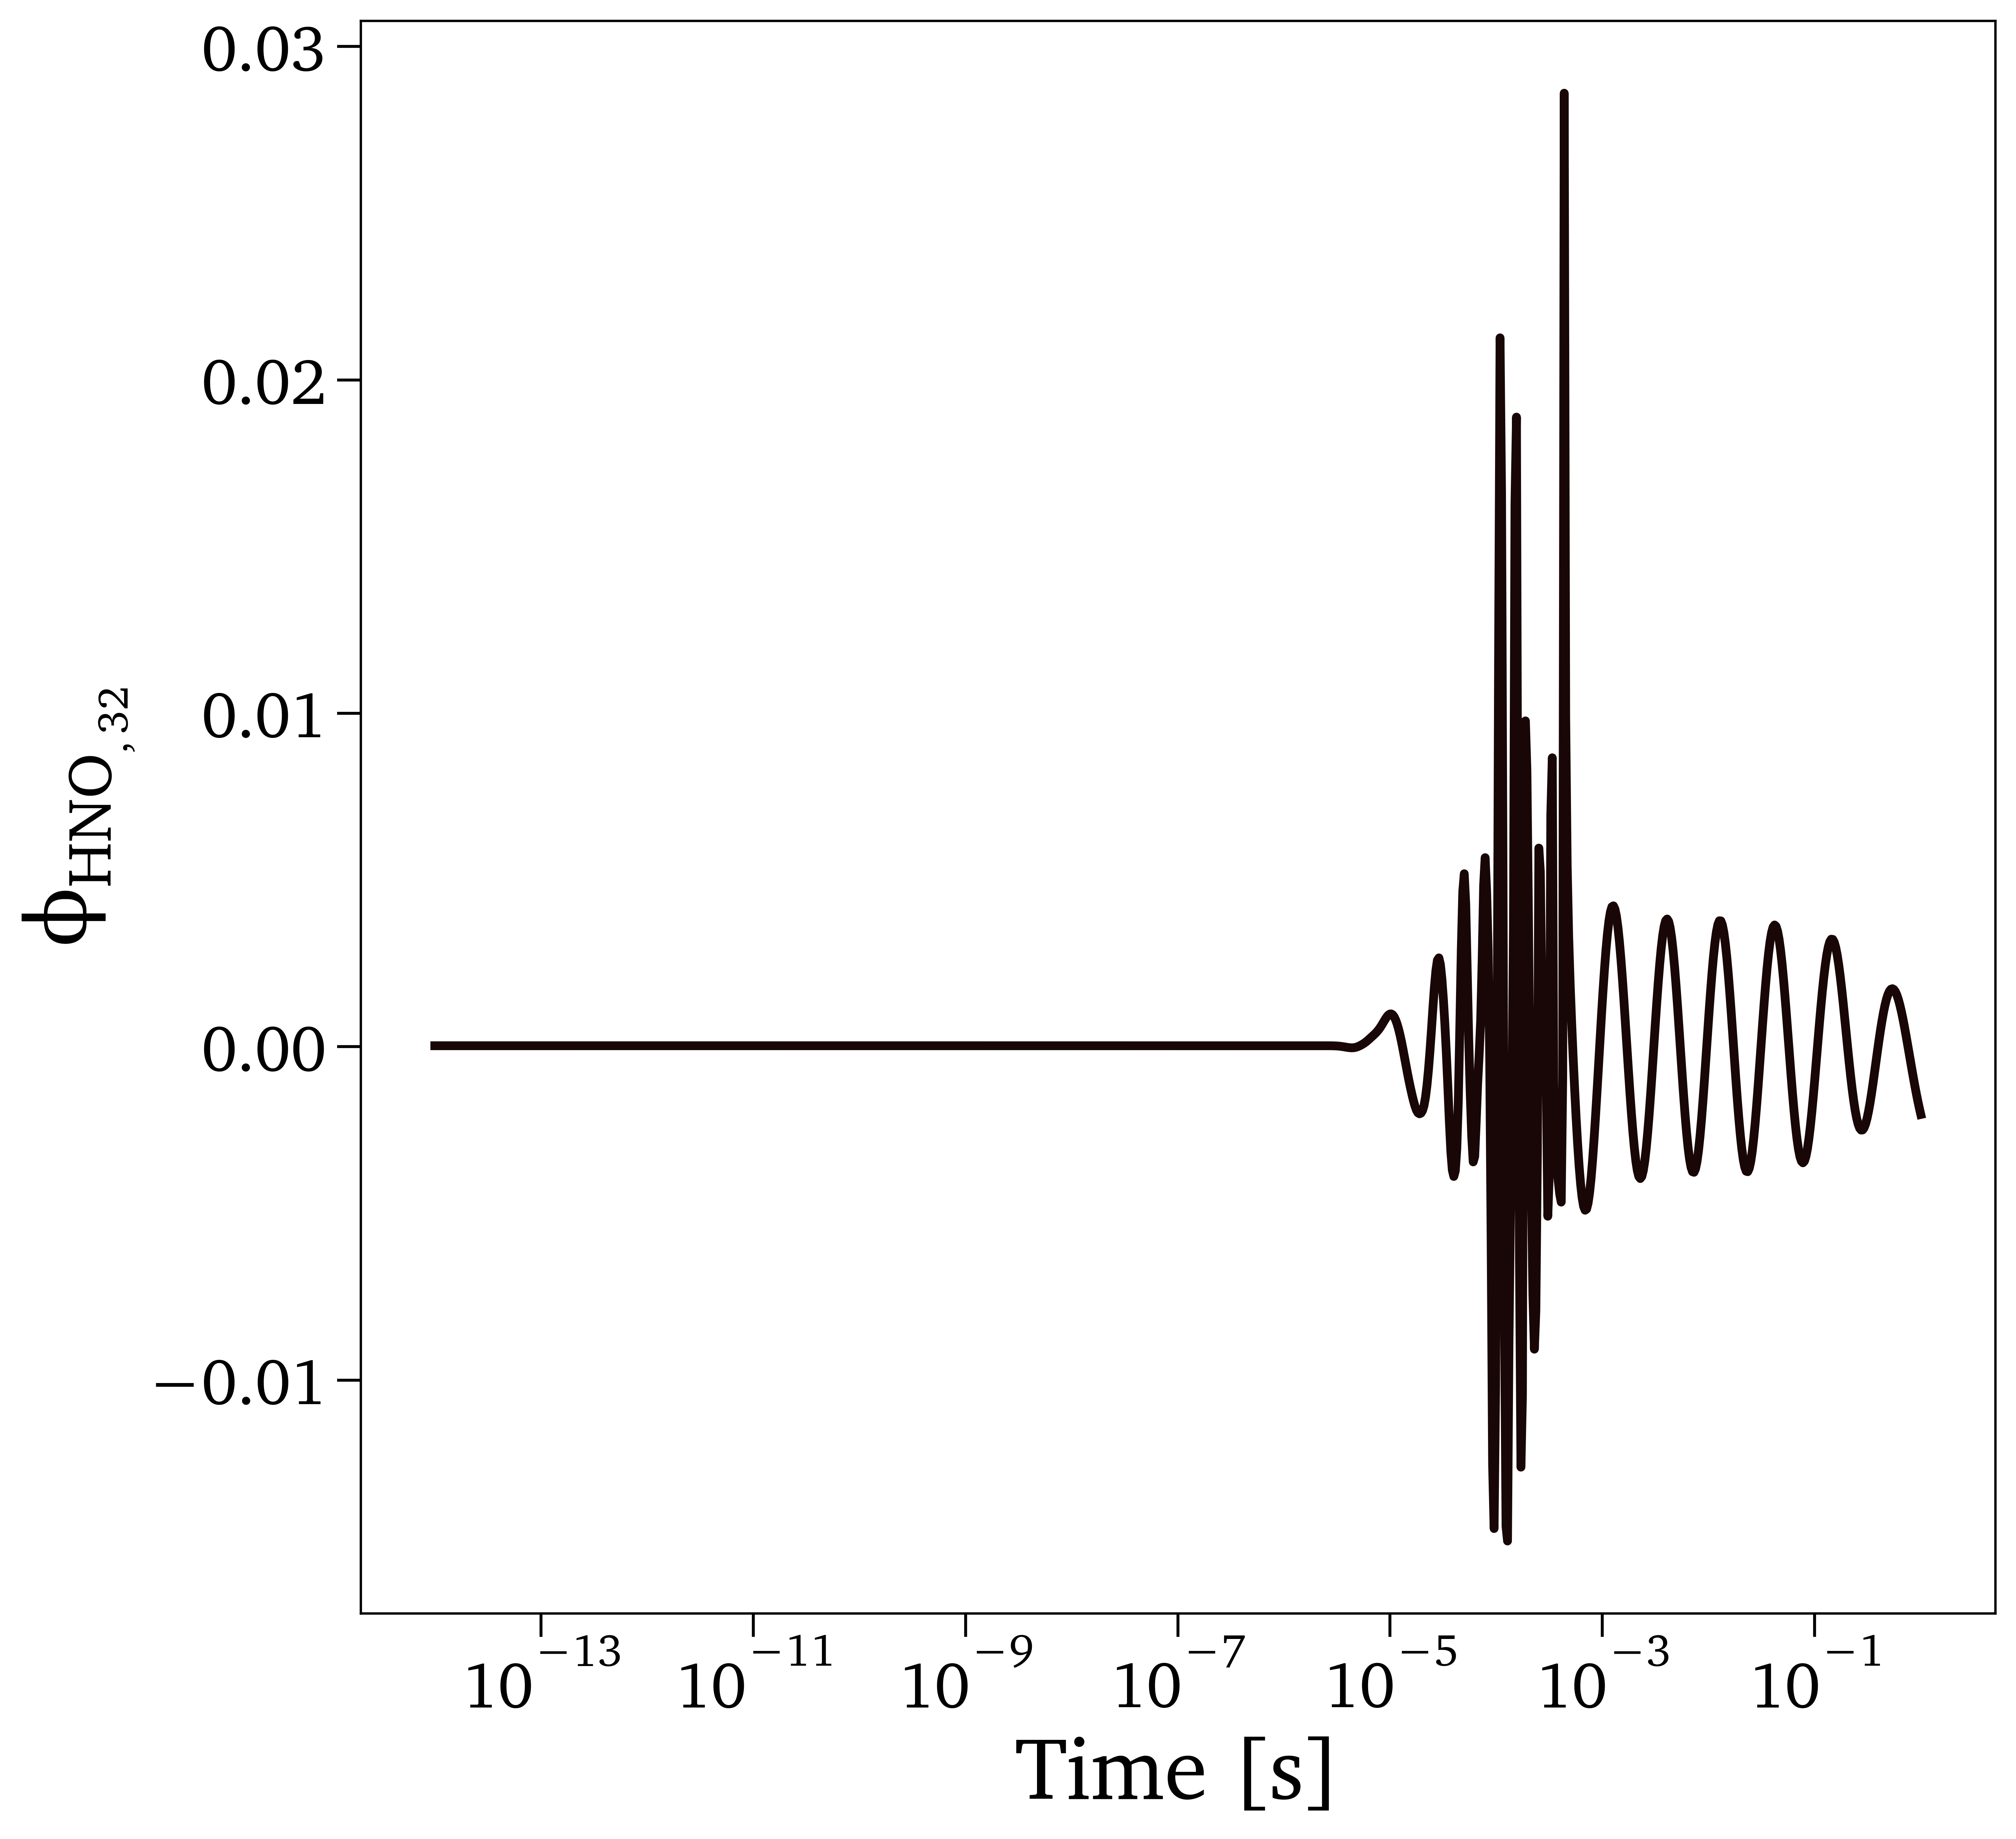

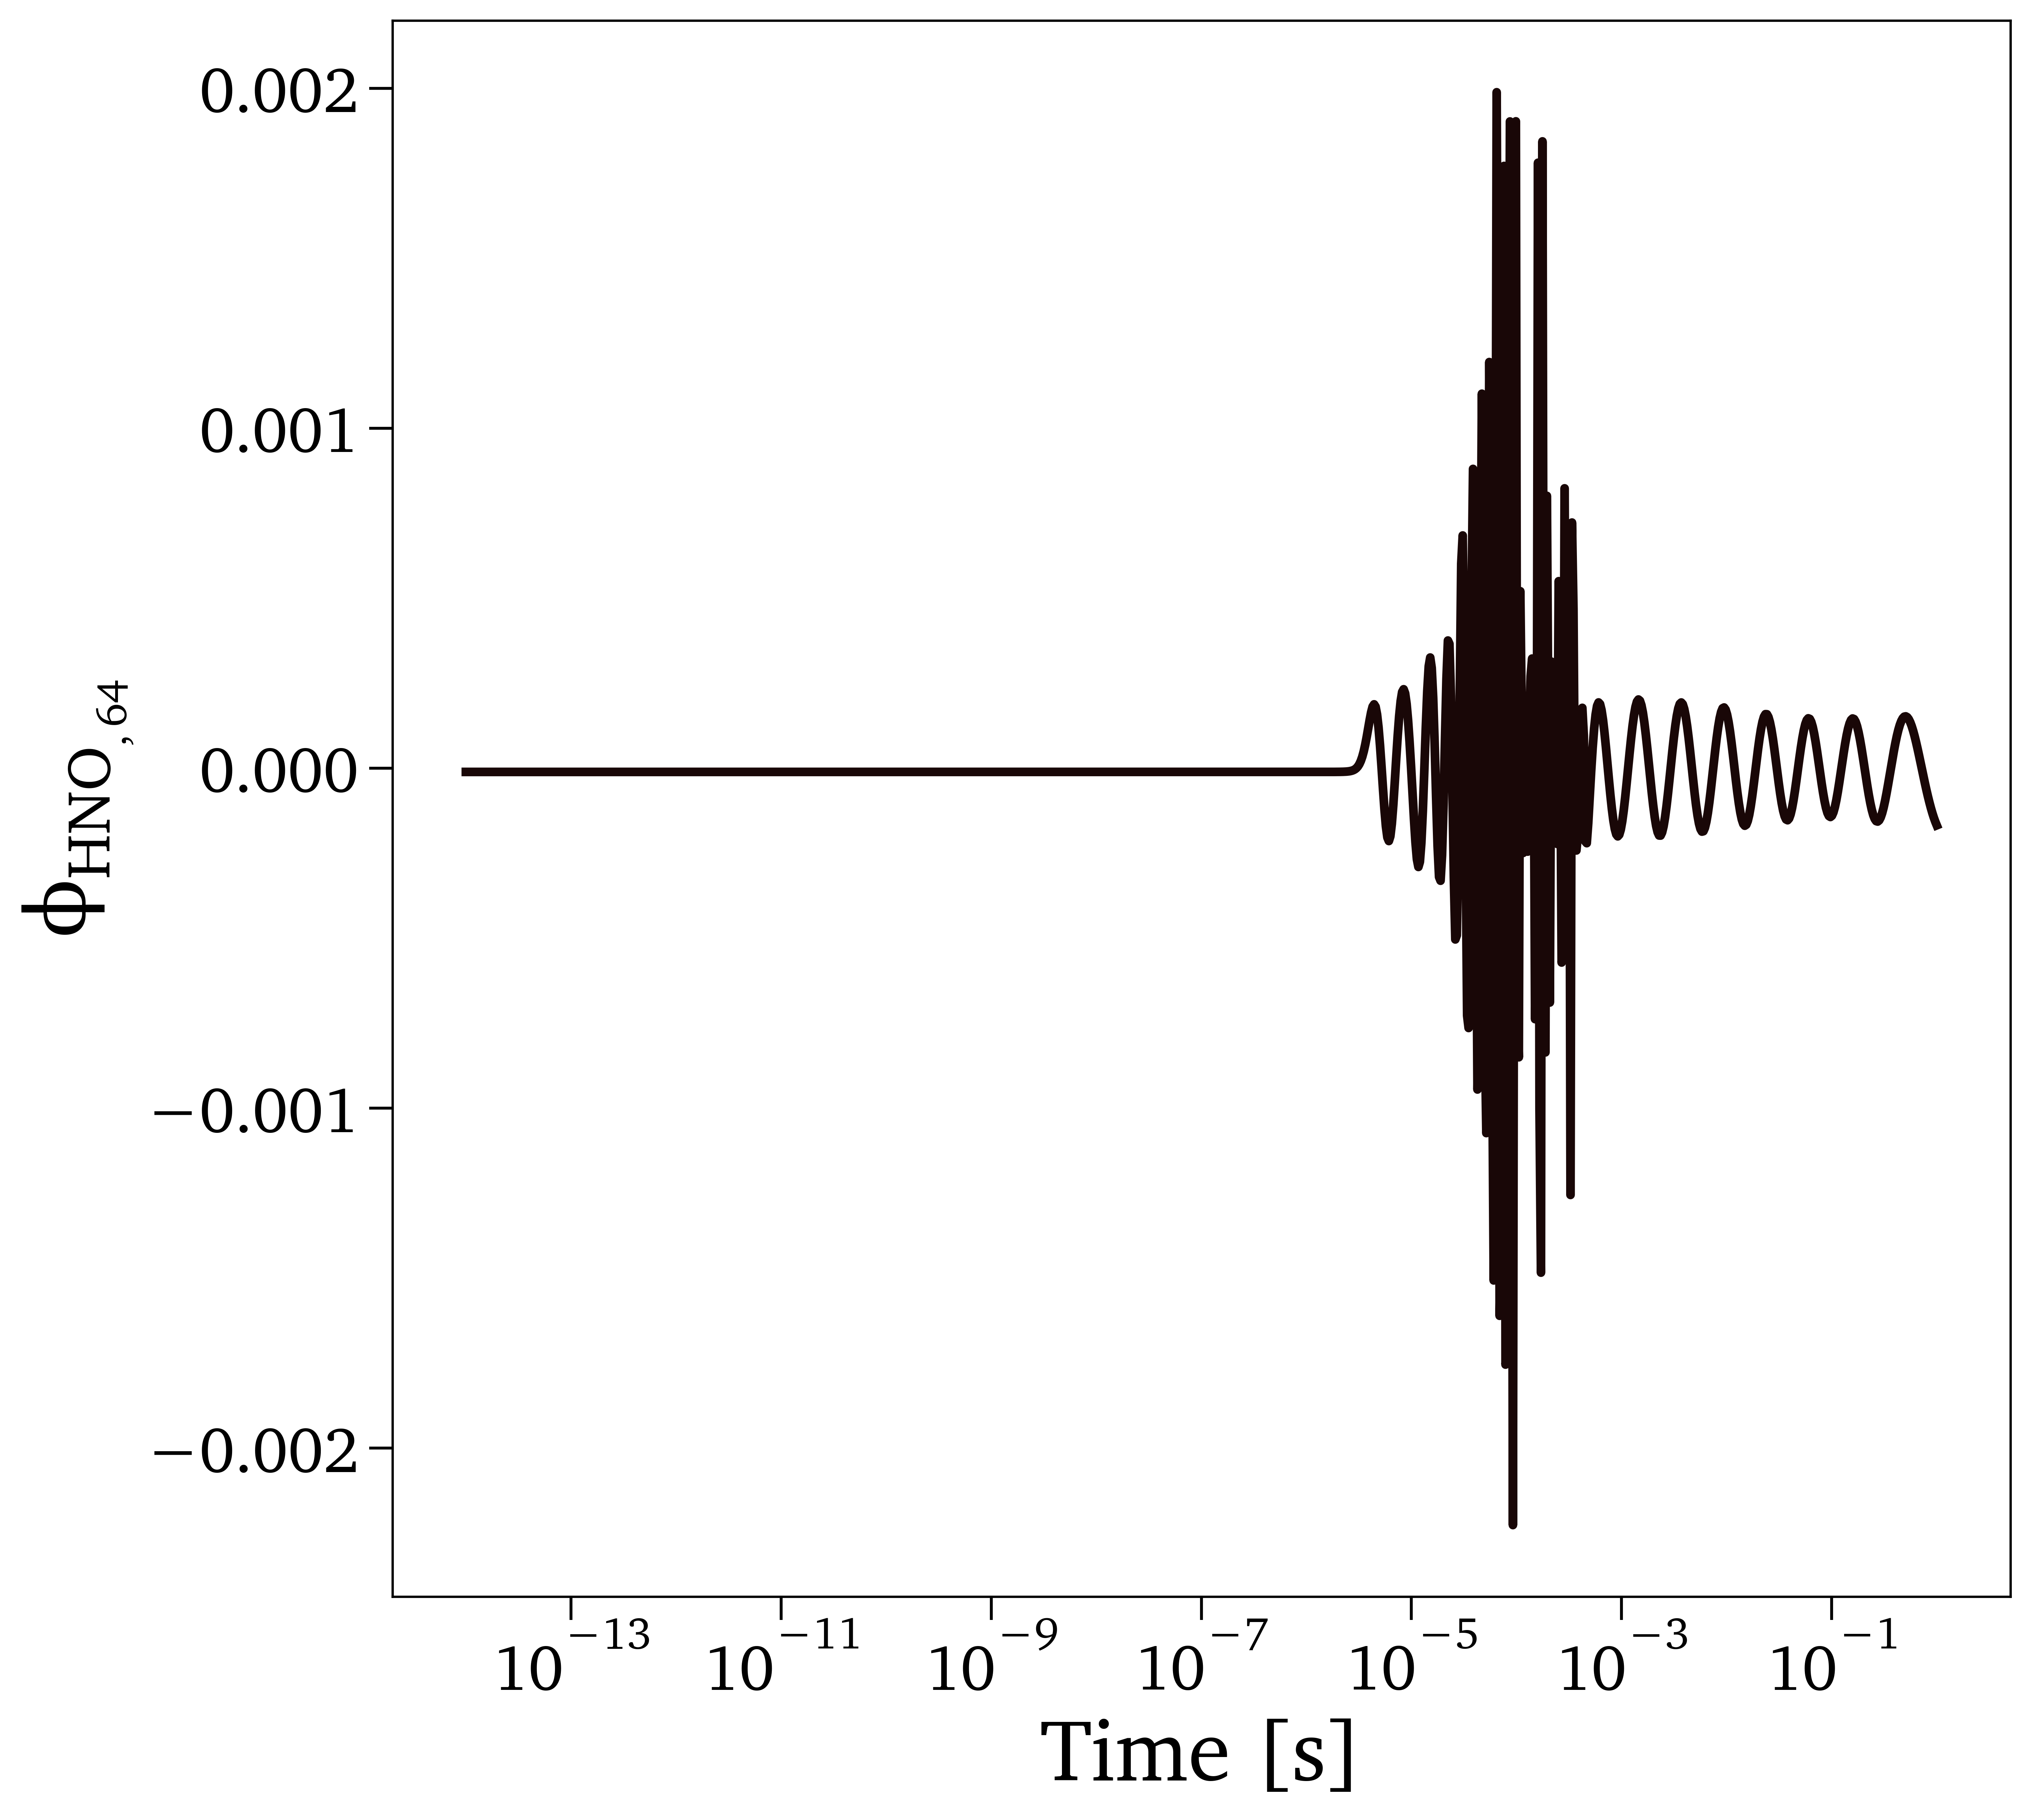

In [21]:
iPCVec = [0,31,63]

for iPC in iPCVec:
    
#     Eta_1   = DataIC.to_numpy()[:,0]
#     Eta_2   = DataIC.to_numpy()[:,1]
#     Alpha_1 = A[iPC,:]

#     fig = plt.figure()
#     ax  = fig.add_subplot(projection='3d')
#     ax.scatter(Eta_1, Eta_2, Alpha_1)

    plt.figure()
    plt.plot(tVec, yMat_pca[:,iPC], '-')
    plt.xscale('log')
    plt.xlabel('Time [s]')
    plt.ylabel(r'$\phi_{{'+VarName+'}_{,'+str(iPC+1)+'}}$')
    #plt.xlim([1.e-6,1.e-4])
    
    if (FigDir):
        plt.savefig(FigDir+'/0DReact_PCA_'+Vars[iVar]+'_phi'+str(iPC+1)+'.eps', format='eps', bbox_inches='tight')